# Part II: Model-based Regularization

Now that we know the main caveats of solving inverse problems, it's time to find out how to tackle them! The keyword here will be **regularization**. A regularization method is usually adapted to the noise level $\delta$ with a regularization parameter $\lambda > 0$ and has two essential properties:
* The regularization method is **continuous** (i.e., stable) for all choices of $\lambda$.
* As the noise level tends to zero, the regularization method **converges pointwise to a generalized inverse** (e.g., the operator that maps a noisy measurement to the minimum norm solution).

A popular class of regularization methods can be formulated as a variational problem, where the reconstruction $x^*$ of a noisy measurement $y^{\delta}$ is obtained as the solution of
$$ x^* = \operatorname*{arg\ min}_x \frac{1}{2}\|Ax-y^{\delta}\|^2_2 + \lambda J(x), $$
where the functional $J$ is called the regularization functional and penalizes unwanted behaviour of $x$. In this part of the tutorial, we will see what typical examples of $J$ look like and get an idea of how the minimizer of the above problem can be found. For a stochastical interpretation of the variational formulation stay tuned for the last part of this tutorial. 

## Tikhonov Regularization

The first regularization functional we consider is $J(x) = \frac{1}{2}\|x\|^2_2 $. An easy interpretation of this would be that **penalizing reconstructions with a large norm prevents the error from exploding** (compare Task 1.4). The resulting variational problem then reads
$$ x^* = \operatorname*{arg\ min}_x \frac{1}{2}\|Ax-y^{\delta}\|^2_2 + \frac{\lambda}{2} \|x\|^2_2.$$

Analytically, the solution of the above problem can be computed as 
$$ x^* = (A^*A + \lambda \operatorname{Id})^{-1} A^*y,$$
where $A^*$ denotes the adjoint of $A$ and $\operatorname{Id}$ denotes the identity operator. In this form, the method is also known as Tikhonov regularization.

Since we cannot easily access $(A^*A + \lambda \operatorname{Id})^{-1}$, we can perform a simple gradient descent with stepsize $t > 0$ of the form
$$ x \leftarrow x - t \cdot (A^*Ax + \lambda x - A^*y )$$

### &#128221; <span style="color:darkorange"> Task 2.1 </span>
#### Complete the following algorithm that performs gradient descent to solve the Tikhonov regularization problem.

In [2]:
### TODO ###

## Sparsity Promoting Regularization
Another demand on the regularization method could be that the obtained **reconstructions should simple in a certain sense**. This means that they should be composed of only a few building blocks. 

The two ingredients we will need to enforce this are
* an operator $D$ which decomposes $x$ into building blocks, for example a wavelet decomposition
* the $\|\cdot\|_1$-norm which promotes sparsity, i.e., penalizes non-zero entries of $Dx$.

### &#128221; <span style="color:darkorange"> Task 2.2 </span>
#### Try out sparsity promoting regularization for the following choices of $D$ and describe how the reconstructions change depending on $D$:
* Identity
* Blabla Wavelets 
* Diesdas Wavelets

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (9,) + inhomogeneous part.

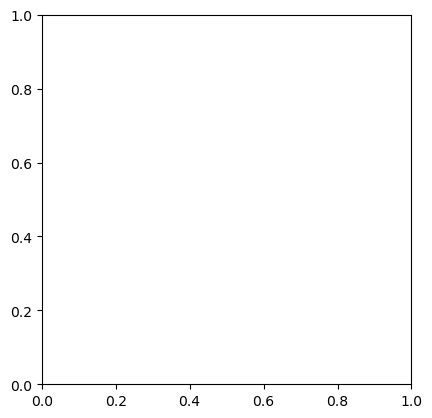

In [4]:
import pywt
import skimage as ski
import matplotlib.pyplot as plt

phantom = ski.data.shepp_logan_phantom()
dec = pywt.wavedec2(phantom, wavelet=pywt.Wavelet('haar'))
plt.imshow(dec)